# Paris Saclay Centre for Data Science
## Blood Sugar RAMP: 
**Solve Blood sugar with Regression**

## Introduction
The goal is to develop prediction models able to predict the sugar in blood.
## Requirements
- numpy>=1.10.0
- matplotlib>=1.5.0
- pandas>=0.19.0
- scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)
- lightgbm >=2.1.0
- seaborn >=0.8.1

## Business Case

Entering the 21st century, life sciences, especially genetic science, have extensively and profoundly affected everyone's healthy life. At the same time, scientists have used an entirely new perspective on genetics to interpret life and explore the nature of the disease. Artificial Intelligence (AI) is capable of processing and analyzing massive medical and health data, acquiring insight through cognitive analysis, serving the government, healthcare institutions, pharmaceutical companies and patients, enabling personalized, evidence-based smart healthcare, driving innovation and delivering value.

For cardiovascular diseases and diabetes mellitus, the annual death toll accounts for 80% of the total deaths. The annual expenditure on chronic diseases accounts for more than 13% of China's public health expenditure. As a common chronic disease, diabetes can not be cured at present, but it can reduce morbidity and improve patients' quality of life through scientific and effective intervention, prevention and treatment. We hope to use artificial intelligence methods and ideas to deal with, analyze, interpret and apply diabetes-related big data to design high-precision, efficient and interpretative algorithms to challenge the scientific problem of the precise prediction of diabetes, providing strong technical support for academia and precision medicine, and helping us to overcome diabetes.

- What do we a we want to predict and how do we measure the quality of the prediction? 
    - We obtained the diabetic blood glucose forecast for each person, expressed in decimal notation, leaving three digits after the decimal point. The results will be compared with the actual detection results. Taking the mean square error as the evaluation index, the smaller the better, the mean square error is calculated as follows:
    ![image.png](01.png)
    Where m is the total number of people, 〖y'〗_i is the ith person's blood glucose level predicted by the player, and y_i is the ith person's actual blood glucose level.
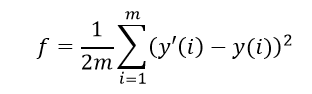

- What data do we need to develop a predictor?
    - The gold standard. We also need the data to judge directly whether the patient is Diabetic. This means that we will need a sample where the label of whatever we want to predict is available. Right now, we have just the blood glucose concentration which is not the direct data to prove whether the patient is Diabetic.

In [1]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns

/root/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Exploratory data analysis
### Loading the data

Let's start by reading the data.<br>
We split data into 4 parts : X_train, X_test, y_train, y_test <br>
We can noticce that there are several columns including age, id and so on. <br>
There are also some columns named Att1,Att2, they are also some indexes describing the condition of the body, we did a change for their names of columns, because their orignal names are in another language.

In [2]:
data_path = './data/'

data = pd.read_csv(data_path+'train.csv')

X_train, X_test, y_train, y_test  = train_test_split(data[data.columns.difference(['blood_sugar'])],data['blood_sugar'], test_size=0.2)
X_train.head()

,Att1,Att10,Att11,Att12,Att13,Att14,Att15,Att16,Att17,Att18,...,Att4,Att5,Att6,Att7,Att8,Att9,age,date,id,sex
299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,49,26/10/2017,3074,F
854,40.57,6.07,1.17,4.20,4.74,66.35,437.90,NaN,NaN,NaN,...,55.88,73.52,44.66,28.86,1.55,2.87,37,22/09/2017,2056,M
3731,17.91,4.28,1.58,2.32,3.63,53.38,296.08,NaN,NaN,NaN,...,26.54,76.53,43.33,33.20,1.31,0.86,33,13/10/2017,56,F
3257,25.00,5.04,1.51,3.30,4.02,84.28,364.30,0.04,2.53,0.01,...,56.58,69.94,43.34,26.60,1.63,0.84,44,31/10/2017,4838,M
2575,33.74,4.94,1.60,2.96,4.95,92.98,404.14,NaN,NaN,NaN,...,21.31,75.55,39.36,36.19,1.09,0.87,69,09/10/2017,1815,M


This is the summary of our dataframe.<br>
We can notice that they are not balanced.<br>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4513 entries, 0 to 4512
Data columns (total 42 columns):
id             4513 non-null int64
sex            4513 non-null object
age            4513 non-null int64
date           4513 non-null object
Att1           3521 non-null float64
Att2           3521 non-null float64
Att3           3521 non-null float64
Att4           3521 non-null float64
Att5           3521 non-null float64
Att6           3521 non-null float64
Att7           3521 non-null float64
Att8           3521 non-null float64
Att9           3527 non-null float64
Att10          3527 non-null float64
Att11          3527 non-null float64
Att12          3527 non-null float64
Att13          3406 non-null float64
Att14          3406 non-null float64
Att15          3406 non-null float64
Att16          1078 non-null float64
Att17          1078 non-null float64
Att18          1078 non-null float64
Att19          1078 non-null float64
Att20          1078 non-null float64
Att21      

Different indexes of our data

In [4]:
data.describe()

,id,age,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,...,Att29,Att30,Att31,Att32,Att33,Att34,Att35,Att36,Att37,blood_sugar
count,4513.000000,4513.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,...,4498.000000,4495.000000,4495.000000,4495.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4513.000000
mean,2856.245956,45.584312,26.904416,27.856589,87.350704,38.876072,76.747319,45.811110,30.936208,1.503596,...,252.470654,10.668543,13.323003,0.267717,56.677234,33.843286,6.847177,2.028991,0.604513,5.646043
std,1647.068350,12.918029,14.249655,23.442640,26.156164,38.965280,4.048512,2.632604,3.617524,0.227019,...,59.386109,0.982625,2.192411,0.060617,7.805456,7.294341,1.562331,1.683314,0.288324,1.579919
min,1.000000,3.000000,10.040000,0.120000,22.980000,6.360000,57.320000,29.540000,7.060000,0.520000,...,37.000000,7.100000,8.000000,0.050000,14.400000,9.600000,3.100000,0.000000,0.000000,3.070000
25%,1434.000000,35.000000,20.250000,15.230000,70.070000,17.700000,74.180000,44.130000,28.540000,1.360000,...,213.000000,10.000000,11.700000,0.230000,51.500000,28.800000,5.800000,0.900000,0.400000,4.930000
50%,2859.000000,45.000000,23.950000,21.480000,84.260000,26.210000,76.540000,45.810000,30.730000,1.490000,...,248.000000,10.600000,12.900000,0.260000,56.700000,33.700000,6.700000,1.600000,0.600000,5.300000
75%,4273.000000,54.000000,29.330000,32.370000,99.900000,44.570000,79.540000,47.590000,33.180000,1.630000,...,288.000000,11.300000,14.600000,0.300000,61.900000,38.600000,7.700000,2.500000,0.800000,5.770000
max,5732.000000,91.000000,434.950000,498.890000,374.320000,480.990000,100.410000,53.900000,66.180000,7.120000,...,745.000000,15.200000,25.300000,0.710000,84.500000,76.300000,23.200000,22.500000,3.500000,38.430000


Type of data of different columns

In [5]:
data.dtypes

id               int64
sex             object
age              int64
date            object
Att1           float64
Att2           float64
Att3           float64
Att4           float64
Att5           float64
Att6           float64
Att7           float64
Att8           float64
Att9           float64
Att10          float64
Att11          float64
Att12          float64
Att13          float64
Att14          float64
Att15          float64
Att16          float64
Att17          float64
Att18          float64
Att19          float64
Att20          float64
Att21          float64
Att22          float64
Att23          float64
Att24          float64
Att25          float64
Att26          float64
Att27          float64
Att28          float64
Att29          float64
Att30          float64
Att31          float64
Att32          float64
Att33          float64
Att34          float64
Att35          float64
Att36          float64
Att37          float64
blood_sugar    float64
dtype: object

Heatmap of Correlation coefficient

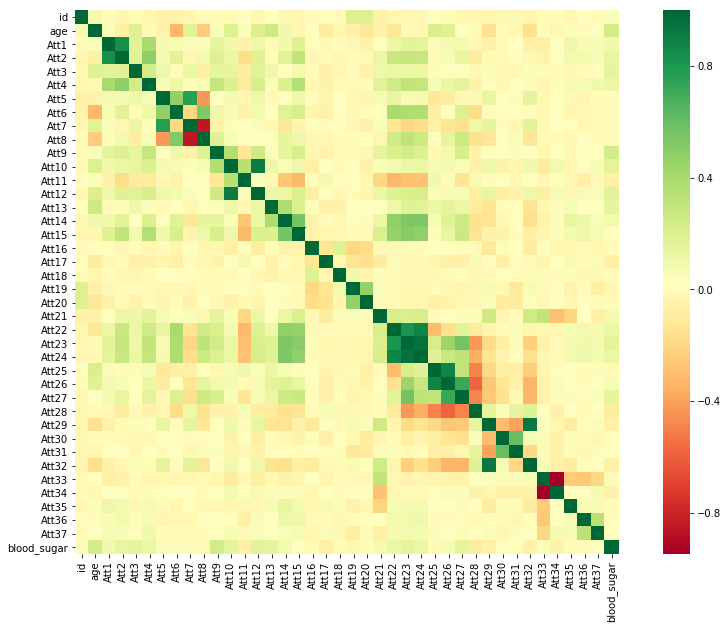

In [6]:
plt.figure(figsize=(16,10))
sns.heatmap(data.corr(), square=True,cmap='RdYlGn')
plt.show()

This is the numerical distribution of data. <br>
We can notice that those values are very different, some graphs corresponds to the distribution of poisson and some data have the long tail distribution.

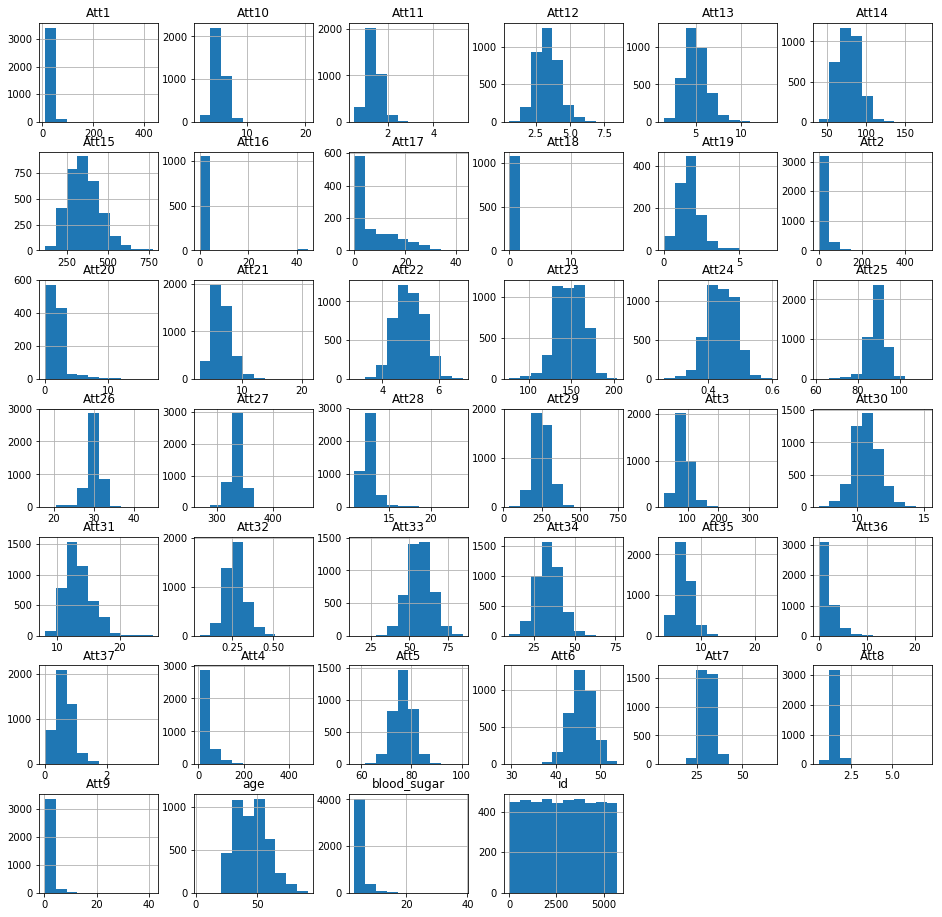

In [7]:
data.hist(figsize=(16, 16))
plt.show()

We detect the missing value for every column and the percentage of missing values

In [8]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Att17,3435,0.761135
Att20,3435,0.761135
Att16,3435,0.761135
Att18,3435,0.761135
Att19,3435,0.761135
Att15,1107,0.245291
Att13,1107,0.245291
Att14,1107,0.245291
Att4,992,0.219809
Att8,992,0.219809


These graphs presents the blood sugar distribution for different ages.<br>
We can notice that when people are about 40 years old, the blood sugar is higher than the value of blood sugar of other ages.

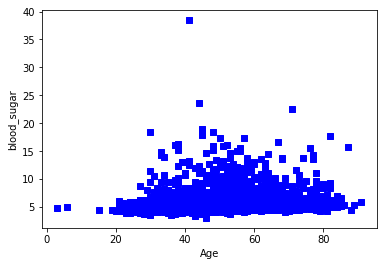

In [9]:
plt.scatter(data['age'], data['blood_sugar'], c = "blue", marker = "s")
plt.xlabel("Age")
plt.ylabel("blood_sugar")
plt.show()

The purpose of this function is to process the data, because of the existence of strings in our data, so we changed that data to a number.<br>
For example, man : 1, woman : 0

In [10]:
def make_feat(train,test):
    train['sex'] = train['sex'].map({'M':1,'F':0})
    train['date'] = (pd.to_datetime(train['date']) - parse('2018-01-26')).dt.days
    train.fillna(train.median(axis=0),inplace=True)
       
    test['sex'] = test['sex'].map({'M':1,'F':0})
    test['date'] = (pd.to_datetime(test['date']) - parse('2018-01-26')).dt.days
    test.fillna(test.median(axis=0),inplace=True)
    return train,test

X_train_feat, X_test_feat = make_feat(X_train,X_test)
X_train_feat.head(5)
train_feat = pd.concat([X_train_feat, y_train.to_frame()], axis=1)
test_feat = pd.concat([X_test_feat, y_test.to_frame()], axis=1)
X_train_feat.head(5)

,Att1,Att10,Att11,Att12,Att13,Att14,Att15,Att16,Att17,Att18,...,Att4,Att5,Att6,Att7,Att8,Att9,age,date,id,sex
299,24.00,5.15,1.34,3.32,4.89,78.09,347.23,0.05,3.58,0.04,...,26.18,76.55,45.82,30.77,1.49,1.43,49,-92,3074,0.0
854,40.57,6.07,1.17,4.20,4.74,66.35,437.90,0.05,3.58,0.04,...,55.88,73.52,44.66,28.86,1.55,2.87,37,-126,2056,1.0
3731,17.91,4.28,1.58,2.32,3.63,53.38,296.08,0.05,3.58,0.04,...,26.54,76.53,43.33,33.20,1.31,0.86,33,-105,56,0.0
3257,25.00,5.04,1.51,3.30,4.02,84.28,364.30,0.04,2.53,0.01,...,56.58,69.94,43.34,26.60,1.63,0.84,44,-87,4838,1.0
2575,33.74,4.94,1.60,2.96,4.95,92.98,404.14,0.05,3.58,0.04,...,21.31,75.55,39.36,36.19,1.09,0.87,69,-138,1815,1.0


The function evalerror is to calculate the rmse <br>
Then we use the lgboost to do the train and prediction, we did 5 fold cross validation. <br>
We can notice that the score is good.

In [11]:
predictors = [f for f in test_feat.columns if f not in ['blood_sugar']]
def evalerror(pred, df):
    label = df.get_label().values.copy()
    score = mean_squared_error(label,pred)*0.5
    return ('0.5mse',score,False)

print('Training...')
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'colsample_bytree': 0.7,
    'feature_fraction': 0.7,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}



print('with 5-fold...')
t0 = time.time()
train_preds = np.zeros(train_feat.shape[0])
test_preds = np.zeros((X_test_feat.shape[0], 5))
kf = KFold(len(train_feat), n_folds = 5, shuffle=True, random_state=520)
for i, (train_index, test_index) in enumerate(kf):
    print('The {} train...'.format(i))
    train_feat1 = train_feat.iloc[train_index]
    train_feat2 = train_feat.iloc[test_index]
    lgb_train1 = lgb.Dataset(train_feat1[predictors], train_feat1['blood_sugar'])
    lgb_train2 = lgb.Dataset(train_feat2[predictors], train_feat2['blood_sugar'])
    gbm = lgb.train(params,
                    lgb_train1,
                    num_boost_round=3000,
                    valid_sets=lgb_train2,
                    verbose_eval=100,
                    feval=evalerror,
                    early_stopping_rounds=100)
    feat_imp = pd.Series(gbm.feature_importance(),index=predictors).sort_values(ascending=False)
    #print(feat_imp)
    train_preds[test_index] += gbm.predict(train_feat2[predictors])
    test_preds[:,i] = gbm.predict(X_test_feat[predictors])
    print(feat_imp)
print('Score：    {}'.format(mean_squared_error(train_feat['blood_sugar'],train_preds)*0.5))
print('During Time'.format(time.time() - t0))

# submission = pd.DataFrame({'pred':test_preds.mean(axis=1)})
# submission.to_csv(r'sub{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),header=None,
#                   index=False, float_format='%.4f')


Training...
with 5-fold...
The 0 train...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.66871	valid_0's 0.5mse: 0.834354
[200]	valid_0's l2: 1.60935	valid_0's 0.5mse: 0.804674
[300]	valid_0's l2: 1.58069	valid_0's 0.5mse: 0.790347
[400]	valid_0's l2: 1.57229	valid_0's 0.5mse: 0.786147
[500]	valid_0's l2: 1.57141	valid_0's 0.5mse: 0.785707
[600]	valid_0's l2: 1.57109	valid_0's 0.5mse: 0.785547
Early stopping, best iteration is:
[529]	valid_0's l2: 1.56888	valid_0's 0.5mse: 0.784441
age      821
date     475
Att9     468
Att1     463
Att25    460
Att3     447
Att28    436
Att22    403
Att23    387
Att21    380
Att13    375
id       361
Att27    359
Att15    356
Att33    333
Att34    328
Att4     322
Att2     299
Att24    295
Att35    276
Att29    268
Att12    263
Att31    258
Att36    233
Att6     226
Att8     218
Att10    211
Att30    205
Att11    204
Att14    197
Att26    191
Att5     174
Att7     165
Att37    130
Att32    122
sex       88
Att16  

### Regressor

<text>The Regressor implements a fit function and a predict function which do the train and predictions. <br>
It is saved in the file submissions/starting_kit/regressor.py. <br>
<h4>Steps : </h4>
1 - Initialization : function init <br>
2 - we use the lightgbmm to do training and predictions : function fit and function predict<br>
</text>


In [12]:
%%file submissions/starting_kit/regressor.py
from sklearn.base import BaseEstimator
import lightgbm as lgb

class Regressor(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, X, y):
        params = {
        'learning_rate': 0.01,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'sub_feature': 0.7,
        'num_leaves': 60,
        'colsample_bytree': 0.7,
        'feature_fraction': 0.7,
        'min_data': 100,
        'min_hessian': 1,
        'verbose': -1,
         }
        self.reg = lgb.train(params,
                    lgb.Dataset(X,y),
                    num_boost_round=300,
                        )
    def predict(self, X):
        return self.reg.predict(X)


<h3>Feature Extractor</h3>
<text>
This document is saved in the file submissions/starting_kit/feature_extractor.py. It use the dataframe defined at the begining of this notebook, this document contains functions permitting to extract features to help to do the classification later.<br>
function clean_dataset : clean the data <br>
This class also implements a transform member function <br>
</text>

In [13]:
%%file submissions/starting_kit/feature_extractor.py
import time
import datetime
import pandas as pd
import numpy as np
from dateutil.parser import parse
class FeatureExtractor():
    def clean_dataset(self,X_df):
        assert isinstance(X_df, pd.DataFrame), "df needs to be a pd.DataFrame"
        #X_df.dropna(inplace=True)
        #indices_to_keep = ~X_df.isin([np.nan, np.inf, -np.inf]).any(1)
        return X_df.astype(np.float64)
    
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        X_df['sex'] = X_df['sex'].map({'M':1,'F':0})
        X_df['date'] = (pd.to_datetime(X_df['date']) - parse('2018-01-26')).dt.days
        X_df.fillna(X_df.median(axis=0),inplace=True)
        X_df = self.clean_dataset(X_df)
        return X_df.values
    

In [14]:
!ramp_test_submission

Testing Blood Suger Regression
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
./submissions/starting_kit/feature_extractor.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_df['sex'] = X_df['sex'].map({'M':1,'F':0})
./submissions/starting_kit/feature_extractor.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_df['date'] = (pd.to_datetime(X_df['date']) - parse('2018-01-26')).dt.days
/root/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopy